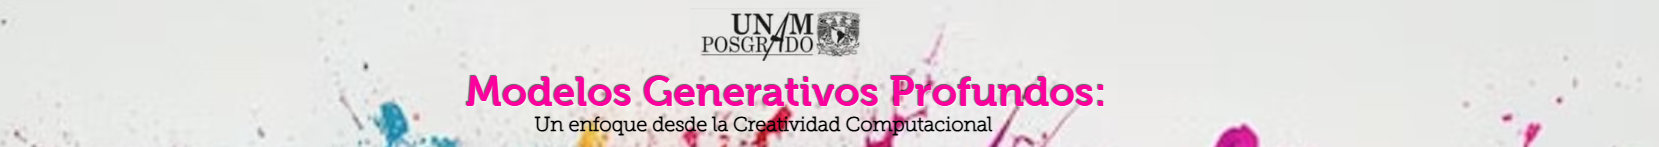

# Exploración del Decodificador de DALL·E 2 (Kandinsky 2.2)

Este notebook permite **probar el comportamiento del *decoder*** de un modelo tipo DALL·E 2,
utilizando la implementación abierta **Kandinsky 2.1** de Hugging Face.  

El *decoder* es el componente que **convierte embeddings visuales en imágenes finales**,
guiado por el texto del prompt.  

Flujo:
Texto → Prior → Decoder → Imagen.



## 1. Instalar dependencias

In [1]:
!pip install diffusers transformers accelerate torch -q
!pip install xformers -q

zsh:1: command not found: pip
zsh:1: command not found: pip


## 2. Importar librerías

In [2]:
import torch
from diffusers import KandinskyPipeline, KandinskyPriorPipeline, KandinskyImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt

/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Cargar los modelos (Prior + Decoder)

In [3]:
from diffusers import KandinskyPriorPipeline, KandinskyPipeline
import torch

import os 

def setConfig():
    """
    Configura el dispositivo para PyTorch y spaCy según la disponibilidad de hardware.
    Devuelve el dispositivo configurado.
    """
    if torch.backends.mps.is_available():
        # Usar MPS (Metal Performance Shaders) en macOS
        device = torch.device("mps")
    elif torch.cuda.is_available():
        # Usar CUDA (GPU NVIDIA) si está disponible
        device = torch.device("cuda")
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    else:
        # Usar CPU como fallback
        device = torch.device("cpu")
    try:
        torch.ones(1, device=device)
    except Exception as e:
        print("Error:", e)
        raise e
    
    return device

device = setConfig()

# 1. Cargar el prior (texto → embeddings visuales)
prior = KandinskyPriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1-prior",
    torch_dtype=torch.float16
).to(device)

# 2. Cargar el decodificador
decoder = KandinskyPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1",
    torch_dtype=torch.float16
).to(device)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


## 4. Generar embeddings visuales desde el texto

In [4]:
prompt = "a watercolor painting of a cat wearing a space helmet"

# Generar ambos embeddings con el prior
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds

100%|██████████| 25/25 [00:02<00:00,  9.06it/s]


## 5. Generar imagen con el decodificador

100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


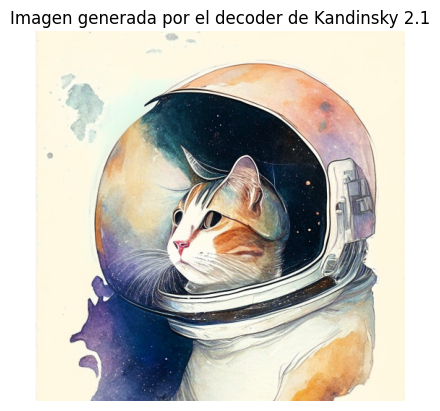

In [5]:
# Usar el decodificador para generar la imagen final
result = decoder(
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,  # ← agregado
    prompt=prompt,
    num_inference_steps=50
)

# Mostrar la imagen resultante
image = result.images[0]
plt.imshow(image)
plt.axis("off")
plt.title("Imagen generada por el decoder de Kandinsky 2.1")
plt.show()



## 6. Prueba adicional: generar varias imágenes con diferentes prompts

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


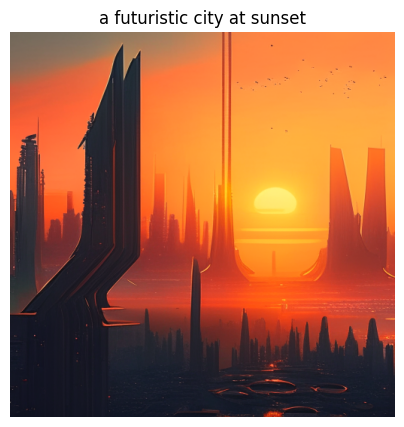

100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


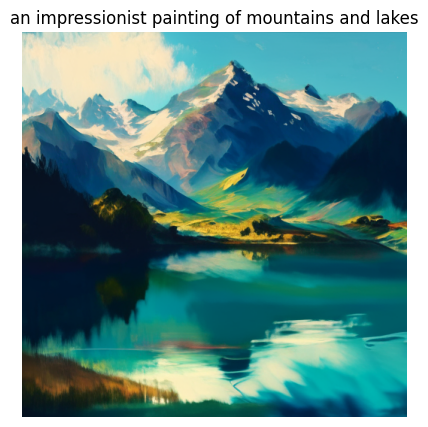

100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


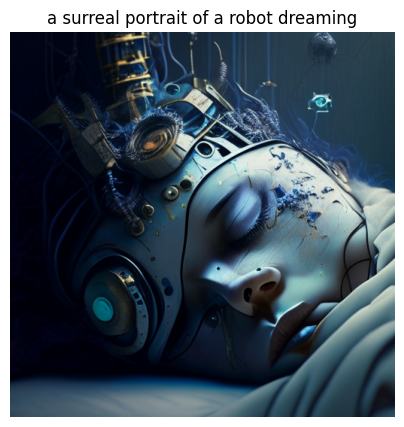

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


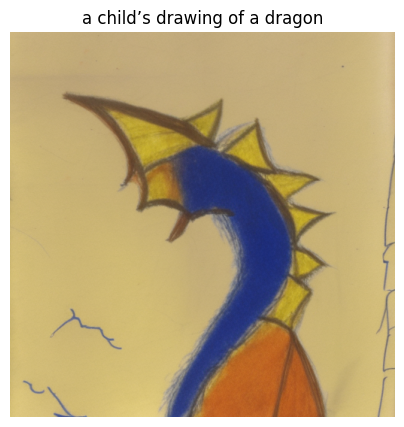

In [6]:
# Prueba con nuevos prompts
prompts = [
    "a futuristic city at sunset",
    "an impressionist painting of mountains and lakes",
    "a surreal portrait of a robot dreaming",
    "a child’s drawing of a dragon"
]

for p in prompts:
    # 1. Generar ambos embeddings con el prior
    prior_output = prior(p)
    image_embeds = prior_output.image_embeds
    negative_image_embeds = prior_output.negative_image_embeds

    # 2. Usar el decodificador para generar la imagen
    result = decoder(
        image_embeds=image_embeds,
        negative_image_embeds=negative_image_embeds,
        prompt=p,
        num_inference_steps=50
    )

    # 3. Mostrar el resultado
    img = result.images[0]
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(p, fontsize=12)
    plt.show()


### Ejercicio 1: Evolución del proceso de difusión

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


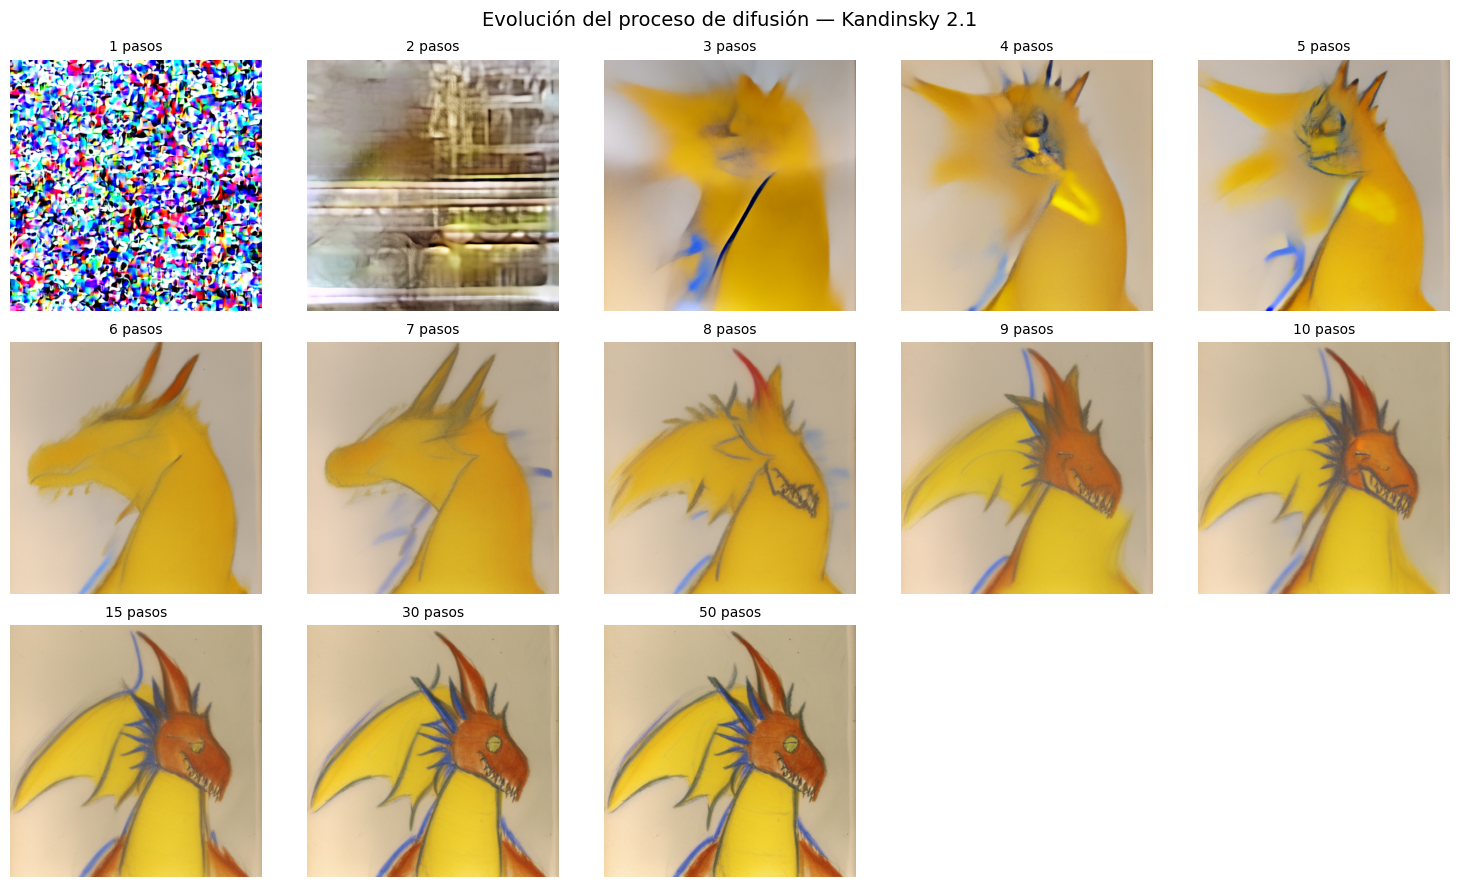

In [7]:
# ------------------------------------------------
# Generar imágenes con distintos pasos de difusión (ruido fijo)
# ------------------------------------------------
steps_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30, 50]  # diferentes niveles de refinamiento

n = len(steps_list)
cols = 5  # número de columnas que quieres mostrar
rows = (n + cols - 1) // cols  # calcula el número de filas necesarias

plt.figure(figsize=(3 * cols, 3 * rows))
seed = 1234  # semilla fija

for i, steps in enumerate(steps_list, 1):
    # Crear un nuevo generador con la MISMA semilla antes de cada paso
    generator = torch.manual_seed(seed)

    result = decoder(
        image_embeds=image_embeds,
        negative_image_embeds=negative_image_embeds,
        prompt=prompt,
        num_inference_steps=steps,
        generator=generator  # mismo ruido inicial
    )
    img = result.images[0]
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{steps} pasos", fontsize=10)

plt.suptitle("Evolución del proceso de difusión — Kandinsky 2.1", fontsize=14)
plt.tight_layout()
plt.show()


### Ejercicio 2. Edición creativa

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


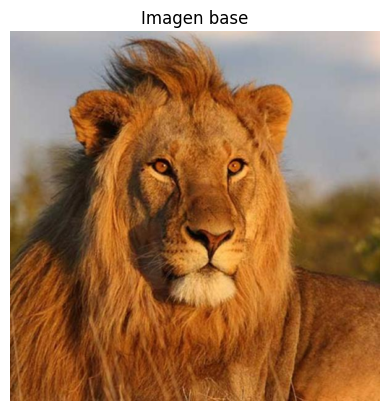

100%|██████████| 45/45 [00:23<00:00,  1.90it/s]


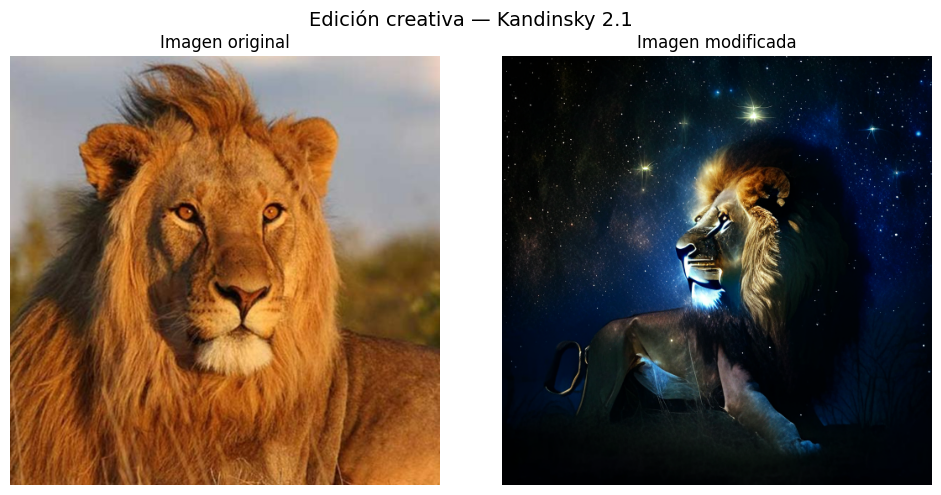

In [9]:
# ------------------------------------------------
# Ejercicio 2 — Edición creativa con Kandinsky 2.1
# ------------------------------------------------


img2img = KandinskyImg2ImgPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-1",
    torch_dtype=torch.float16
).to(device)

# ------------------------------------------------
# 1. Cargar la imagen base
# ------------------------------------------------
image_path = "./Imagenes1/leon1.jpg"
base_image = Image.open(image_path).convert("RGB")
base_image = base_image.resize((512, 512))

plt.imshow(base_image)
plt.axis("off")
plt.title("Imagen base")
plt.show()

# ------------------------------------------------
# 2. Definir el prompt de edición
# ------------------------------------------------
prompt = "the same lion but at night with glowing stars"

# ------------------------------------------------
# 3. Generar embeddings a partir del texto
# ------------------------------------------------
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds

# ------------------------------------------------
# 4. Ejecutar la edición (imagen + texto)
# ------------------------------------------------
# El parámetro strength (0 – 1):
# 0 ≈ mantiene casi igual la imagen original,
# 1 ≈ la reinterpreta completamente según el texto.
result = img2img(
    prompt=prompt,
    image=base_image,
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,
    strength=0.9,  # controla cuánto cambia respecto a la imagen original
    num_inference_steps=50
)

edited_image = result.images[0]

# ------------------------------------------------
# 5. Mostrar la comparación visual
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(base_image)
plt.axis("off")
plt.title("Imagen original")

plt.subplot(1, 2, 2)
plt.imshow(edited_image)
plt.axis("off")
plt.title("Imagen modificada")

plt.suptitle("Edición creativa — Kandinsky 2.1", fontsize=14)
plt.tight_layout()
plt.show()



### Ejercicio 3. Edición fina

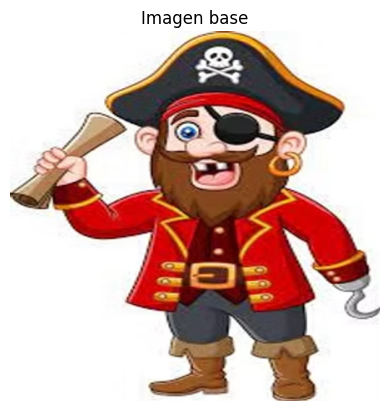

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


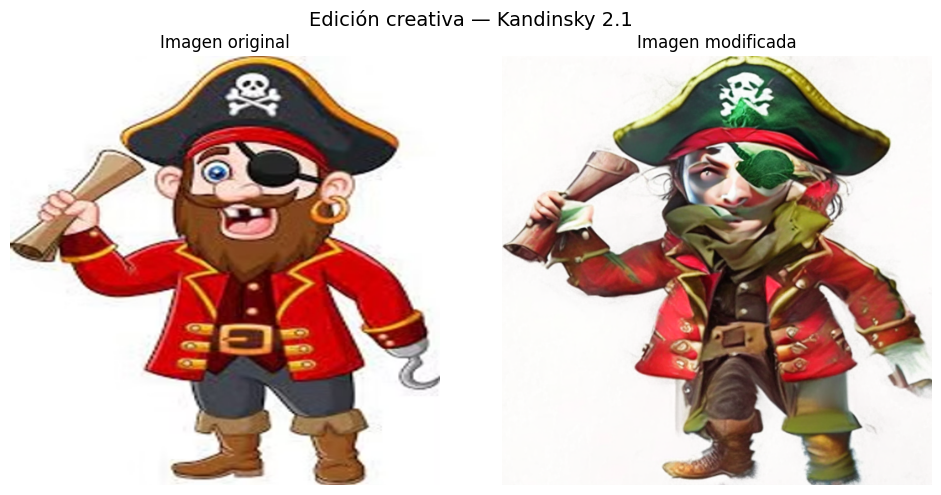

In [18]:
# ------------------------------------------------
# Ejercicio 3 — Edición fina
# ------------------------------------------------


# ------------------------------------------------
# 1. Cargar la imagen base
# ------------------------------------------------
image_path = "./pirata.jpg"
base_image = Image.open(image_path).convert("RGB")
base_image = base_image.resize((512, 512))

plt.imshow(base_image)
plt.axis("off")
plt.title("Imagen base")
plt.show()

# ------------------------------------------------
# 2. Definir el prompt de edición
# ------------------------------------------------
prompt = "the same pirate but now with a green jacket"

# ------------------------------------------------
# 3. Generar embeddings a partir del texto
# ------------------------------------------------
prior_output = prior(prompt)
image_embeds = prior_output.image_embeds
negative_image_embeds = prior_output.negative_image_embeds

# ------------------------------------------------
# 4. Ejecutar la edición (imagen + texto)
# ------------------------------------------------
# El parámetro strength (0 – 1):
# 0 ≈ mantiene casi igual la imagen original,
# 1 ≈ la reinterpreta completamente según el texto.
result = img2img(
    prompt=prompt,
    image=base_image,
    image_embeds=image_embeds,
    negative_image_embeds=negative_image_embeds,
    strength=0.15,  # controla cuánto cambia respecto a la imagen original
    num_inference_steps=20
)

edited_image = result.images[0]

# ------------------------------------------------
# 5. Mostrar la comparación visual
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(base_image)
plt.axis("off")
plt.title("Imagen original")

plt.subplot(1, 2, 2)
plt.imshow(edited_image)
plt.axis("off")
plt.title("Imagen modificada")

plt.suptitle("Edición creativa — Kandinsky 2.1", fontsize=14)
plt.tight_layout()
plt.show()
